## New_Contributors_of_Commits
This is the reference implementation for [New Contributors of Commits](https://github.com/chaoss/wg-evolution/blob/master/metrics/pull-requests-merge-contributor-new.md),
a metric specified by the
[Evolution Working Group](https://github.com/chaoss/wg-evolution) of the
[CHAOSS project](https://chaoss.community).
This implementation is specific to Git repositories.

Have a look at [README.md](README.md) to find out how to run this notebook (and others in this directory) as well as to get a better understanding of the purpose of the implementations.

The implementation is described in two parts (see below):

* Class for computing New_Contributors_of_Commits
* An explanatory analysis of the class' functionality

Some more auxiliary information in this notebook:

* Examples of the use of the implementation
* Visualizing the data extracted

As discussed in the [README](README.md) file, the scripts required to analyze the data fetched by Perceval are located in the `code_df` package. Due to python's import system, to import modules from a package which is not in the current directory, we have to either add the package to `PYTHONPATH` or simply append a `..` to `sys.path`, so that `code_df` can be successfully imported. 

In [1]:
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import sys
sys.path.append('..')
from code_df import utils
from code_df.is_source_code import IsSourceCode, ExtensionExclude
from code_df.commit import Commit
%matplotlib inline

In [2]:
class NewContributorsoFCommits(Commit):
    """
    Class for New contributors of commits.

    :param items: A list of dictionaries, each element a line from the
        JSON file with Perceval data
    :param date_range: A tuple which represents the start and end date of
        interest
    :param issrccode_obj: An object of IsSourceCode, to be used to determine
        what comprises source code.
    """

    def __init__(self, items, date_range=(None, None), issrccode_obj=None):
        super().__init__(items, date_range, issrccode_obj)

    def compute(self, check_range=(None, None)):
        """
        Count number of new committers who committed between the two dates
        of check range.

        :param check_range: A tuple which represents the start and end date
            when new committers will be considered

        :returns count: the number of new committers who committed
            between the dates of check_range
        """
        self.check_since, self.check_until = check_range

        if self.check_since is None:
            self.check_since = self.since

        if self.check_until is None:
            self.check_until = self.until

        df = self.df[self.df['created_date'] < self.check_since]

        committers_before_check_since = set()
        committers_before_check_since = set(df['author'].tolist())
        count_new_committers = 0
        df_new_committers = self.df['author'][
                    (self.check_since <= self.df['created_date'])
                    & (self.check_until >= self.df['created_date'])
                    & (~self.df['author']
                        .isin(
                            list(committers_before_check_since)))
                ]
        count_new_committers = len(df_new_committers.unique())
        return count_new_committers

    def compute_timeseries(self, period='month'):
        """
        The metric value is computed for each fixed interval of time
        from the "since" date to the "until" date arguments, specified
        during object initiation.

        The fixed time interval can be either a month or a week.

        :param period: A string which can be either "month" or "week"

        :returns dataframe: A DataFrame whose rows each represent an interval
            of "period" and the count for that interval
        """
        old_committers = set()

        def count_new(series):
            """
            An aggregate function that calculates only those values which
            are new in a grouping as compared to a previous dataframe
            grouping

            :param series: a pandas Series

            :returns count: the number of new elements in series
            """
            nonlocal old_committers

            count = len(series[~series.isin(list(old_committers))].unique())
            old_committers.update(series.tolist())
            return count

        df = self.df
        if period == 'month':
            timeseries_series = df['author'] \
                .groupby([df['created_date'].dt.year.rename('year'),
                          df['created_date'].dt.month.rename('month')]) \
                .agg(count_new)

            all_periods = pd.DataFrame(
                            pd.date_range(self.since, self.until, freq='M'),
                            columns=['Dates'])
            all_periods = pd.DataFrame(
                [all_periods['Dates'].dt.year.rename('year'),
                 all_periods['Dates'].dt.month.rename("month")]).T

        elif period == 'week':
            timeseries_series = df['author'] \
                .groupby([df['created_date'].dt.year.rename('year'),
                          df['created_date'].dt.week.rename('week')])   \
                .agg(count_new)

            all_periods = pd.DataFrame(
                            pd.date_range(self.since, self.until, freq='W'),
                            columns=['Dates'])
            all_periods = pd.DataFrame(
                [all_periods['Dates'].dt.year.rename('year'),
                 all_periods['Dates'].dt.week.rename('week')]).T

        else:
            raise ValueError("period parameter can take 'month' or 'week'")

        timeseries_df = pd.DataFrame(timeseries_series)
        timeseries_df.reset_index(inplace=True)
        timeseries_df.columns = ['year', period, 'new_committers']
        merged_df = all_periods.merge(timeseries_df, how='outer').fillna(0)

        dataframe = merged_df
        return dataframe


## Performing the Analysis
Using the above class, we can perform several kinds of analysis on the JSON data file, fetched by Perceval. 

At its most basic, the `NewContributorsoFCommits` class can be used to get the number of contributors over the entire interval for which commits are considered, that is, all commits that lie between the `since` and `until` dates passed while creating an object for the above class.

The `check_since` and `check_until` arguments are slightly different from `since` and `until`. While the latter talk about what commits in the data are even considered, `check_since` and `check_until` give us a range in which we actively look for new contributors of commits --- those who had not committed before `check_since`.

### Counting the total number of committers
We first create a IsSourceCode object with a `ExtensionExclude` implementation, and then pass that as well the data of the JSON file as a list to NewContributorsoFCommits. To reiterate, this algorithm, which we are using to define source code checks the extensions of files to determine if they fall under the label of source code. We will also pass a list of extensions we want to exclude. 

In [3]:
sourcecode = IsSourceCode(source_code_exclude_list=['ipynb'], algorithm_class=ExtensionExclude)
items = utils.read_JSON_file('../git-commits.json')

Let's use the `compute` method to count the total number of valid commits made. First, we will do it without passing any `since` and `until` dates as well as no `check_since` and `check_until`. In the class above, we can see that if either of `check_since` or `check_until` are `None`, they are assigned the  corresponding value of `since` or `until`. What this means is that when no values are passed for `check_range`, which is the tuple with `check_since` and `check_until` as elements, every contributor to make a commit is a new contributor and hence, we get the total number of unique contributors between `since` and `until`. 

In [4]:
new_committers = NewContributorsoFCommits(items, issrccode_obj=sourcecode)
print("The total number of new committers is: {}".format(new_committers.compute()))

The total number of new committers is: 29


Now, lets give the `check_range` tuple as a subset of the `date_range` tuple, which has `since` and `until` as its elements. To keep it simple, lets pass no values for `date_range`. Since `since` and `until` are now `None`, they are reassigned the dates of the earliest and latest events in our data. 
Let `check_range` be between 2018-01-01 and 2018-07-01. 

In [5]:
date_since = datetime.strptime("2018-01-01", "%Y-%m-%d")
date_until = datetime.strptime("2018-07-01", "%Y-%m-%d")
new_committers_interval = NewContributorsoFCommits(
                                                    items, 
                                                    (date_since, date_until), 
                                                    issrccode_obj=sourcecode)

print("The total number of new committers between 2018-01-01 and 2018-07-01 in the file is: {}"    \
                      .format(new_committers_interval.compute()))

The total number of new committers between 2018-01-01 and 2018-07-01 in the file is: 10


## Counting commits over regular time intervals
Using the `compute_timeseries` method, it is possible to compute the number of new committers for every month, or for every week. This kind of analysis is useful in finding trends over time, as we will see in the cell below. Let's see the change in lets see the trend in the number of new committers who first committed between the same dates we used above, on a weekly basis: 2018-01-01 and 2018-07-01. We will use the same object we used when working with the dates above: `new_committers_interval`

In [6]:
weekly_df = new_committers_interval.compute_timeseries("week")

Lets see what the dataframe returned by `compute_timeseries` looks like. As you will notice, the dataframe has rows corresponding to each and every week between the start and end dates. A simple merge between the dataframes of all possible weeks and the commit count dataframe (which would of course, be missing several rows(weeks) where there would be no commits) gave us this output. 

In [7]:
weekly_df

,year,week,new_committers
0,2018,1,2
1,2018,2,2
2,2018,3,1
3,2018,4,0
4,2018,5,0
5,2018,6,0
6,2018,7,1
7,2018,8,0
8,2018,9,0
9,2018,10,1


Lets plot the dataframe `weekly_df` using matplotlib.pyplot. We use the `seaborn` theme and plot a simple bar plot --- `new_committer` count vs time interval. 

Text(0.5, 1.0, 'Commit Timeseries')

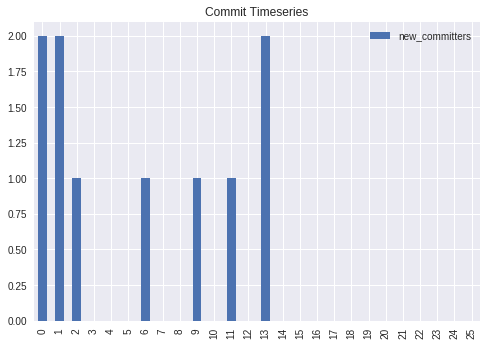

In [8]:
plt.style.use('seaborn')
weekly_df.plot(kind='bar', y='new_committers', use_index=True)
plt.title("Commit Timeseries")

The same thing can be done for months, instead of weeks. By passing `month` in place of week, we get a similar dataframe but with only a few rows, due to the larger timescale of each period. 